Importing the required libraries

In [4]:
# Required Libraries
!pip install tensorflow-addons
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 16.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
# Load the PlantVillage dataset
(ds_train, ds_val), ds_info = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/54303 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/1.0.2.incompleteLNZ77O/plant_village-train.tfrecord*...:   0…

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


In [6]:
# Preprocess function
def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, depth=ds_info.features['label'].num_classes)
    return image, label

In [7]:
# Preprocess the datasets
train_ds = ds_train.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = ds_val.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [8]:
# Batch the datasets
batch_size = 32
train_ds = train_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [9]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image

In [10]:
class_names = ds_info.features['label'].names
print(f"Class names: {class_names}")
print(len(class_names))

Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    'best_model_VGG19.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

In [ ]:
num_classes = 38
num_epochs = 20
# Load the pre-trained VGG19 model without the top classification layer
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add a new classification layer on top
x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)  # VGG commonly uses 4096 units in the first couple of FC layers
x = Dense(4096, activation='relu')(x)  # Add another Dense layer to mimic the architecture of VGG
predictions = Dense(num_classes, activation='softmax')(x)

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
# Create the transfer learning model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=num_epochs, callbacks=[checkpoint_callback])

Epoch 1/20
1358/1358 [==============================] - ETA: 0s - loss: 0.8088 - accuracy: 0.8068
Epoch 1: val_loss improved from inf to 0.42141, saving model to best_model_VGG19.h5
1358/1358 [==============================] - 435s 310ms/step - loss: 0.8088 - accuracy: 0.8068 - val_loss: 0.4214 - val_accuracy: 0.8711
Epoch 2/20
1358/1358 [==============================] - ETA: 0s - loss: 0.2871 - accuracy: 0.9063
Epoch 2: val_loss improved from 0.42141 to 0.32628, saving model to best_model_VGG19.h5
1358/1358 [==============================] - 399s 294ms/step - loss: 0.2871 - accuracy: 0.9063 - val_loss: 0.3263 - val_accuracy: 0.9007
Epoch 3/20
1358/1358 [==============================] - ETA: 0s - loss: 0.2218 - accuracy: 0.9285
Epoch 3: val_loss did not improve from 0.32628
1358/1358 [==============================] - 387s 285ms/step - loss: 0.2218 - accuracy: 0.9285 - val_loss: 0.3685 - val_accuracy: 0.8918
Epoch 4/20
1358/1358 [==============================] - ETA: 0s - loss: 0.17

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(val_ds)

340/340 [==============================] - 72s 211ms/step - loss: 0.4268 - accuracy: 0.9351


We got an Accuracy of 93.51%


In [12]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    'best_model_VGG19.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

num_classes = 38
num_epochs = 20
# Load the pre-trained VGG19 model without the top classification layer
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add a new classification layer on top
x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation='sigmoid')(x)  # VGG commonly uses 4096 units in the first couple of FC layers
x = Dense(4096, activation='sigmoid')(x)  # Add another Dense layer to mimic the architecture of VGG
predictions = Dense(num_classes, activation='softmax')(x)

# Create the transfer learning model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=num_epochs, callbacks=[checkpoint_callback])


Epoch 1/20
1358/1358 [==============================] - ETA: 0s - loss: 1.9910 - accuracy: 0.4532
Epoch 1: val_loss improved from inf to 1.24876, saving model to best_model_VGG19.h5
1358/1358 [==============================] - 422s 310ms/step - loss: 1.9910 - accuracy: 0.4532 - val_loss: 1.2488 - val_accuracy: 0.6251
Epoch 2/20
1358/1358 [==============================] - ETA: 0s - loss: 0.9681 - accuracy: 0.6891
Epoch 2: val_loss improved from 1.24876 to 0.81557, saving model to best_model_VGG19.h5
1358/1358 [==============================] - 415s 306ms/step - loss: 0.9681 - accuracy: 0.6891 - val_loss: 0.8156 - val_accuracy: 0.7382
Epoch 3/20
1358/1358 [==============================] - ETA: 0s - loss: 0.8022 - accuracy: 0.7406
Epoch 3: val_loss improved from 0.81557 to 0.78994, saving model to best_model_VGG19.h5
1358/1358 [==============================] - 419s 309ms/step - loss: 0.8022 - accuracy: 0.7406 - val_loss: 0.7899 - val_accuracy: 0.7545
Epoch 4/20
1358/1358 [=============

In [13]:
# Evaluate the model
loss, accuracy = model.evaluate(val_ds)

340/340 [==============================] - 73s 216ms/step - loss: 0.5456 - accuracy: 0.8488


We got 84.88 % Accuracy here.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    'best_model_VGG19.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

num_classes = 38
num_epochs = 20
# Load the pre-trained VGG19 model without the top classification layer
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add a new classification layer on top
x = base_model.output
x = Flatten()(x)
x = Dense(8192, activation='relu')(x)  # VGG commonly uses 8192 units in the first couple of FC layers
x = Dense(8192, activation='relu')(x)  # Add another Dense layer to mimic the architecture of VGG
predictions = Dense(num_classes, activation='softmax')(x)

# Create the transfer learning model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=num_epochs, callbacks=[checkpoint_callback])


Epoch 1/20
1358/1358 [==============================] - ETA: 0s - loss: 0.9950 - accuracy: 0.8004
Epoch 1: val_loss improved from inf to 0.40565, saving model to best_model_VGG19.h5
1358/1358 [==============================] - 479s 351ms/step - loss: 0.9950 - accuracy: 0.8004 - val_loss: 0.4057 - val_accuracy: 0.8705
Epoch 2/20
1358/1358 [==============================] - ETA: 0s - loss: 0.3091 - accuracy: 0.8997
Epoch 2: val_loss did not improve from 0.40565
1358/1358 [==============================] - 442s 326ms/step - loss: 0.3091 - accuracy: 0.8997 - val_loss: 0.4766 - val_accuracy: 0.8658
Epoch 3/20
1358/1358 [==============================] - ETA: 0s - loss: 0.2307 - accuracy: 0.9255
Epoch 3: val_loss improved from 0.40565 to 0.24955, saving model to best_model_VGG19.h5
1358/1358 [==============================] - 518s 381ms/step - loss: 0.2307 - accuracy: 0.9255 - val_loss: 0.2496 - val_accuracy: 0.9280
Epoch 4/20
1358/1358 [==============================] - ETA: 0s - loss: 0.17

The Colab GPU useage maxed out, But looking at the accuracies on 15th Epoch, This model might give an test accuracy of 92%

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(val_ds)

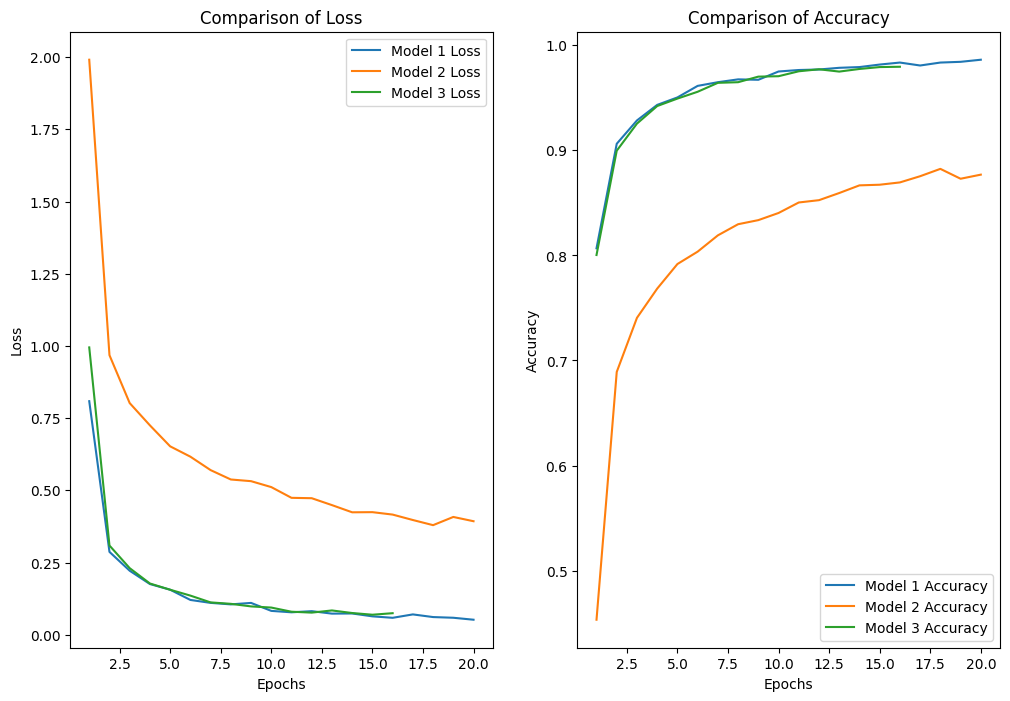

In [4]:
import matplotlib.pyplot as plt

Model1 = {
    "loss": [0.8088, 0.2871, 0.2218, 0.1757, 0.1561, 0.1207, 0.1105, 0.1053, 0.1104, 0.0828, 0.0779, 0.0818, 0.0733, 0.0738, 0.0639, 0.0588, 0.0706, 0.0614, 0.059, 0.0522 ],
    "accuracy": [0.8068, 0.9063, 0.9285, 0.9433, 0.9504, 0.9614, 0.9649, 0.9676, 0.9672, 0.9751, 0.9765, 0.9770, 0.9786, 0.9793, 0.9817, 0.9836, 0.9808, 0.9836, 0.9843, 0.9863]
}
Model2 = {
    "loss": [1.9910, 0.9681, 0.8022, 0.7251, 0.6525, 0.6167, 0.5702, 0.5377, 0.5319, 0.5114, 0.4742, 0.4729, 0.4490, 0.4241, 0.4246, 0.4162, 0.3974, 0.3796, 0.4080, 0.3932],
    "accuracy": [0.4532, 0.6891, 0.7406, 0.7684, 0.7918, 0.8036, 0.8191, 0.8297, 0.8336, 0.8404, 0.8504, 0.8526, 0.8594, 0.8667, 0.8673, 0.8695, 0.8754, 0.8824, 0.8730, 0.8769]
}
Model3 = {
    "loss": [0.9950, 0.3091, 0.2307, 0.1776, 0.1560, 0.1357, 0.1122, 0.1072, 0.0983, 0.0943, 0.0799, 0.0768, 0.0843, 0.0754, 0.0695, 0.0748],
    "accuracy": [0.8004, 0.8997, 0.9255, 0.9422, 0.9493, 0.9558, 0.9643, 0.9649, 0.9702, 0.9706, 0.9753, 0.9772, 0.9750, 0.9775, 0.9793, 0.9796]
}

epochs_range1 = range(1, len(Model1["loss"]) + 1)
epochs_range2 = range(1, len(Model2["loss"]) + 1)
epochs_range3 = range(1, len(Model3["loss"]) + 1)

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range1, Model1["loss"], label='Model 1 Loss')
plt.plot(epochs_range2, Model2["loss"], label='Model 2 Loss')
plt.plot(epochs_range3, Model3["loss"], label='Model 3 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Comparison of Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range1, Model1["accuracy"], label='Model 1 Accuracy')
plt.plot(epochs_range2, Model2["accuracy"], label='Model 2 Accuracy')
plt.plot(epochs_range3, Model3["accuracy"], label='Model 3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Comparison of Accuracy')

plt.show()


______________________________________________________________________END_____________________________________________________________________________